# Infectious Disease Dynamics: Final Project

In [13]:
import numpy as np
from scipy.special import logit
import matplotlib.pyplot as plt
from numpy.random import default_rng

rng = default_rng(seed=42)

from sir_aug import sir_out

from mcmc_aug import (
    run_one_timestep,
    initialize_array,
    calc_log_likelihood,
    proposal_draw,
    run_mcmc,
)

from constants import (
    NEW_YORK_POP_1930,
    VERMONT_POP_1930
)


In [26]:
NEW_YORK_POP_1930*.00005

629.4033000000001

In [ ]:
horrible_guess = -1e10

guess_beta = 36/100
guess_gamma = 2/100
guess_season = .9
guess_peak = 2

# Initial susceptible and infected fractions for New York
guess_s_init_frac_ny = 0.98
guess_i_init_frac_ny = .00005
# guess for rho the reporting rate for New York
guess_rho_ny = 0.5
# guess for mu (death rate) and sigma (birth rate) for New York
guess_mu_ny = 5
guess_sigma_ny = 2

# Initial susceptible and infected fractions for Vermont
guess_s_init_frac_vt = 0.98
guess_i_init_frac_vt = .00005
# guess for rho the reporting rate for Vermont
guess_rho_vt = 0.5
# guess for mu (death rate) and sigma (birth rate) for Vermont
guess_mu_vt = 5
guess_sigma_vt = 2

init_guess_params = np.array([
    np.log(guess_beta),
    np.log(guess_gamma),
    logit(guess_season),
    logit(guess_peak / 12),

    logit(guess_s_init_frac_ny),
    logit(guess_i_init_frac_ny / (1 - guess_s_init_frac_ny)),
    logit(guess_rho_ny),
    logit(guess_mu_ny),
    logit(guess_sigma_ny),

    logit(guess_s_init_frac_vt),
    logit(guess_i_init_frac_vt / (1 - guess_s_init_frac_vt)),
    logit(guess_rho_vt),
    logit(guess_mu_vt),
    logit(guess_sigma_vt)
])

# proposal_standard_dev = np.array([0.05, 0.05, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2])
num_params = len(init_guess_params)


In [23]:
import pandas as pd

obs_cases_df = pd.read_csv(
    "data/measles_in_new_york_and_vermont_1930_1939.csv"
)
obs_cases_df.columns

Index(['month_start', 'new_york_obs_cases', 'vermont_obs_cases'], dtype='object')

In [24]:
observed_data = obs_cases_df[["new_york_obs_cases", "vermont_obs_cases"]].values
num_time_steps = observed_data.shape[0]

In [25]:
# Run the simulation
data_both = sir_out(init_guess_params, rng=rng, num_time_steps=num_time_steps)

In [19]:
data_both[0].shape

(121, 7)

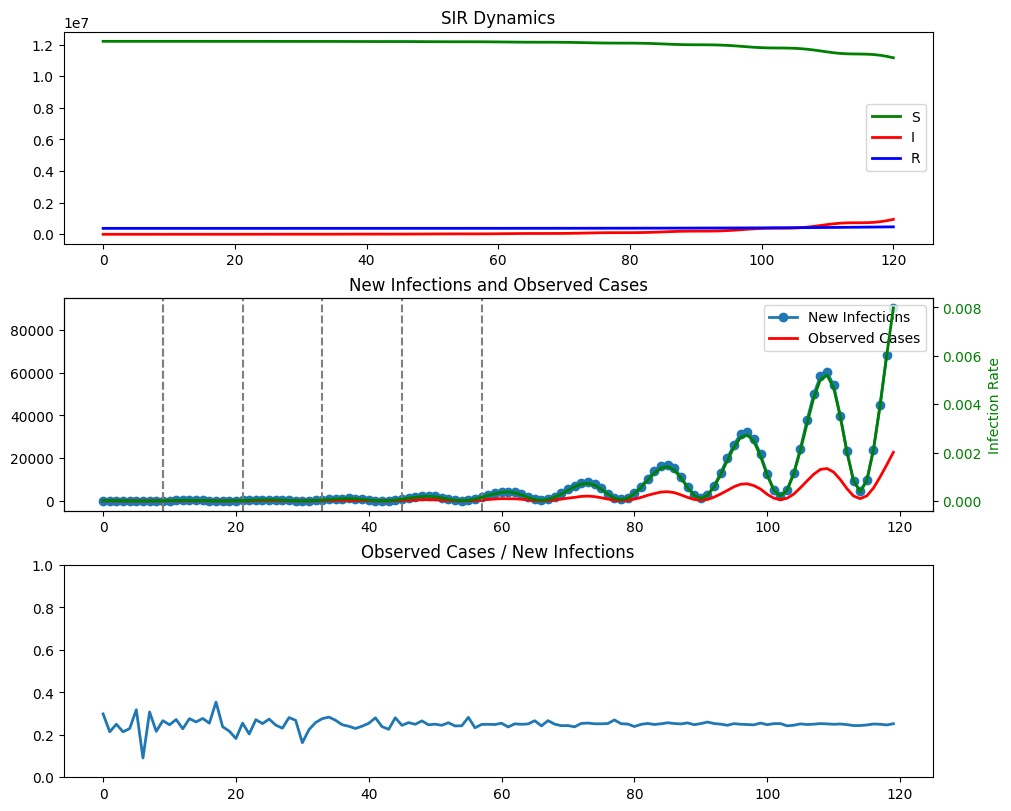

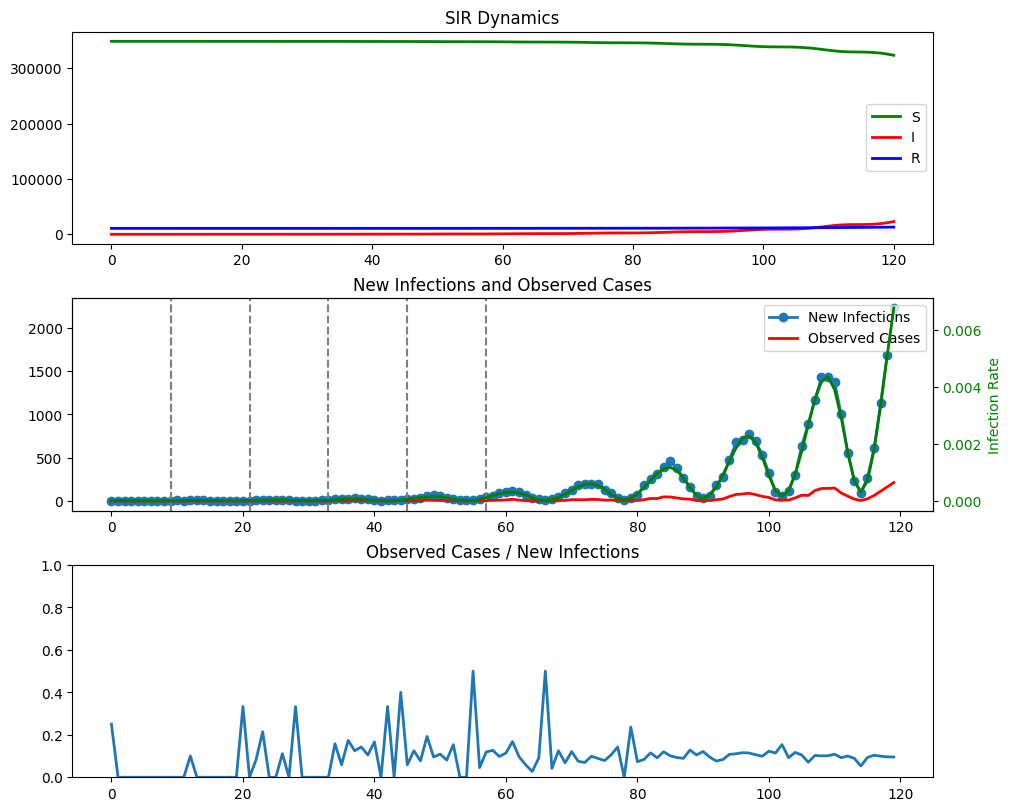

In [20]:
def helper_plot_func(data: np.ndarray):
    # Set up 3 vertically stacked plots with consistent margins
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), constrained_layout=True)

    # First plot: S, I, R over time
    axs[0].plot(data[:, 0], label='S', color='green', linewidth=2)
    axs[0].plot(data[:, 1], label='I', color='red', linewidth=2)
    axs[0].plot(data[:, 2], label='R', color='blue', linewidth=2)
    # axs[0].set_ylim(0, np.nanmax(data[:, 0:3]))
    axs[0].set_title("SIR Dynamics")
    axs[0].legend()

    # Second plot: New Infections and Observed Cases
    axs[1].plot(data[:, 3], marker='o', linestyle='-', linewidth=2, label='New Infections')
    axs[1].plot(data[:, 5], color='red', linewidth=2, label='Observed Cases')

    axs[1].axvline(x=9, linestyle='--', color='gray')  # equivalent to abline at v=9,21,33,45,57
    for x in range(9, 9 + 12 * 4 + 1, 12):
        axs[1].axvline(x=x, linestyle='--', color='gray')

    axs[1].set_title("New Infections and Observed Cases")
    axs[1].legend(loc='upper right')

    # Overlay the infection rate curve from column 6
    ax2 = axs[1].twinx()
    ax2.plot(data[:, 6], color='green', linewidth=2, label='Infection Rate')

    ax2.set_ylabel("Infection Rate", color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Third plot: Observed / New Infections (reporting rate estimate)
    ratio = np.divide(data[:, 5], data[:, 3], out=np.zeros_like(data[:, 5]), where=data[:, 3]!=0)

    axs[2].plot(ratio, linewidth=2)
    axs[2].set_ylim(0, 1)
    axs[2].set_title("Observed Cases / New Infections")

    plt.show()


for data in data_both:
    helper_plot_func(data)

In [21]:
current_params = init_guess_params + proposal_draw(
    proposal_standard_dev=proposal_standard_dev,
    rng=rng,
)

current_run = calc_log_likelihood(
    params=current_params,
    observed_data=observed_data,
    num_time_steps=num_time_steps,
    rng=rng,
)
current_log_likelihood = current_run[0]

try_a_bunch = 100
guess_attempt = 1

while guess_attempt < try_a_bunch and current_log_likelihood <= horrible_guess:
    current_params = proposal_draw(proposal_standard_dev, rng=rng)
    current_run = calc_log_likelihood(current_params, observed_data, num_time_steps=num_time_steps, rng=rng)
    current_log_likelihood = current_run[0]
    guess_attempt += 1

current_latent = current_run[1]

chain = current_params.reshape((num_params, 1))
latents = [current_latent]
accept_chain = [0]  # Use list to accumulate
all_steps = {
    "chain": chain,
    "latents": latents,
    "accept_chain": accept_chain,
    "log_likelihood": [current_log_likelihood],
    "current_latent": current_latent,
}

In [10]:
# Running MCMC steps
all_steps = run_mcmc(
    n_steps=1_000,
    all_steps=all_steps,
    proposal_standard_dev=np.array([.1, .1, .1, .1, .1, .1, .1, .1, .1, .1]),  # Proposal SDs, adjust as needed
    observed_data=observed_data,
    num_time_steps=num_time_steps,
    rng=rng,
)

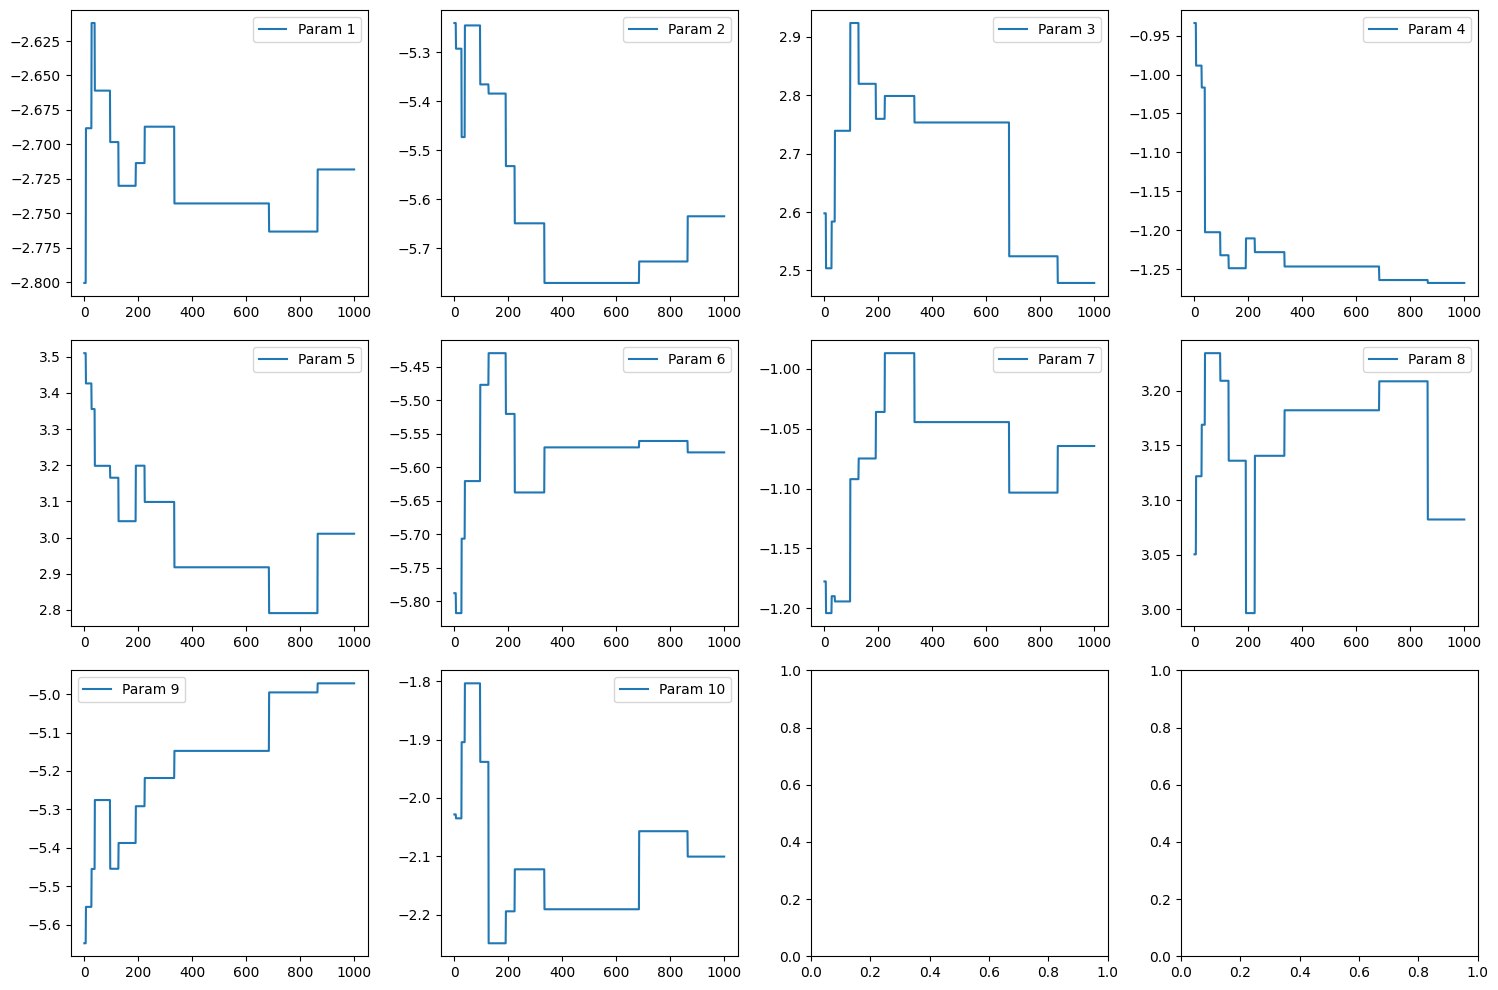

In [11]:
# Plotting parameter chains with target lines
fig, axs = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows, 4 cols layout
axs = axs.flatten()

for par_num in range(num_params):
    # ylim = (np.min(all_steps["chain"][par_num, :]), np.max(all_steps["chain"][par_num, :]))
    axs[par_num].plot(all_steps["chain"][par_num, :], label=f"Param {par_num+1}")
    # axs[par_num].axhline(target_vector[par_num], color='red', linewidth=2, label="Target")
    # axs[par_num].set_ylim(ylim)
    axs[par_num].legend()

plt.tight_layout()
plt.show()


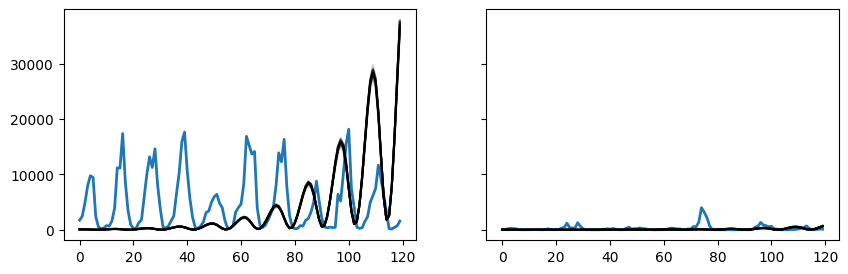

In [12]:
# Plot observed data
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

ax[0].plot(observed_data[:, 0], linewidth=2)  # data[,6] in R is data[:,5] in Python (0-indexed)
ax[1].plot(observed_data[:, 1], linewidth=2)  # data[,6] in R is data[:,5] in Python (0-indexed)

for _ in range(40):
    out = sir_out(all_steps["chain"][:, -1], rng=rng, num_time_steps=num_time_steps)
    ax[0].plot(out[0][:, 5], color=(0, 0, 0, 0.1))  # black with alpha=0.1
    ax[1].plot(out[1][:, 5], color=(0, 0, 0, 0.1))  # black with alpha=0.1

plt.show()

TypeError: tuple indices must be integers or slices, not tuple

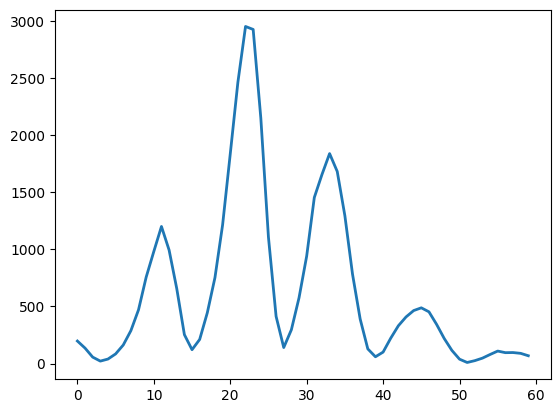

In [14]:
# Plot observed data again
plt.figure()
plt.plot(data[:, 5], linewidth=2)

for _ in range(40):
    out = sir_out(target_vector, rng=rng)
    plt.plot(out[:, 5], color=(0, 0, 0, 0.1))

plt.show()

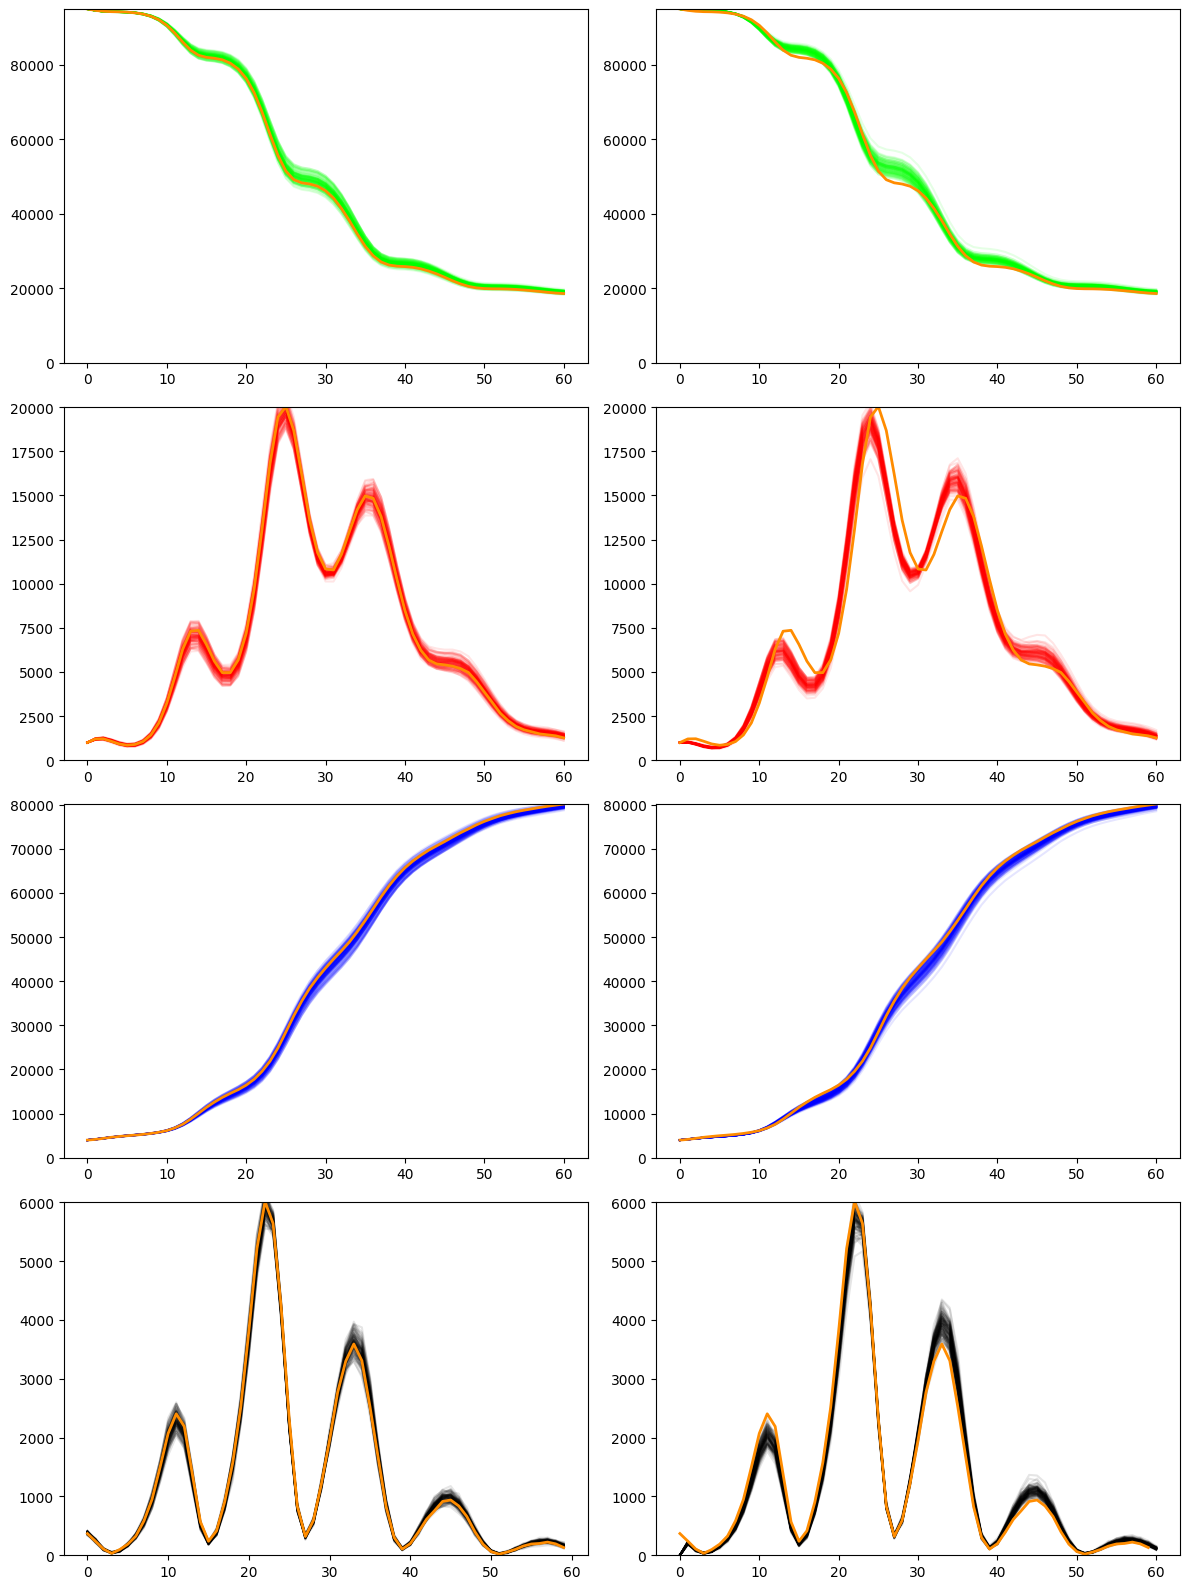

In [ ]:

# Generate list of SIR outputs for each particle
data_list = [sir_out(target_vector, rng=rng) for _ in range(DEFAULT_NUM_PARTICLES)]

# Initialize array and simulate for all particles across time steps
sir_out_all_months = initialize_array(target_vector)  # shape: (DEFAULT_NUM_PARTICLES, DEFAULT_NUM_TIME_STEPS+1, 4)

for month_step in range(DEFAULT_NUM_TIME_STEPS):
    sir_out_all_months[:, month_step + 1, :] = run_one_timestep(
        current_latent_states=sir_out_all_months[:, month_step, :],
        which_month=month_step + 1,
        params=target_vector,
        rng=rng,
    )

# Setup 4 rows x 2 columns of plots
fig, axs = plt.subplots(4, 2, figsize=(12, 16))
axs = axs.flatten()

colors = [
    (0, 1, 0, 0.1),  # green transparent
    (0, 1, 0, 0.1),  # green transparent
    (1, 0, 0, 0.1),  # red transparent
    (1, 0, 0, 0.1),  # red transparent
    (0, 0, 1, 0.1),  # blue transparent
    (0, 0, 1, 0.1),  # blue transparent
    (0, 0, 0, 0.1),  # black transparent
    (0, 0, 0, 0.1),  # black transparent
]

for i, col in enumerate([0, 0, 1, 1, 2, 2, 3, 3]):
    # Determine which list to draw from (even indices: data_list, odd: sir_out_all_months)
    if i % 2 == 0:
        for p_num in range(DEFAULT_NUM_PARTICLES):
            axs[i].plot(data_list[p_num][:, col], color=colors[i])
    else:
        for p_num in range(DEFAULT_NUM_PARTICLES):
            axs[i].plot(sir_out_all_months[p_num, :, col], color=colors[i])

    # Plot data line
    # axs[i].plot(data[:, col], color=["green", "green", "red", "red", "blue", "blue", "black", "black"][i], linewidth=2)
    axs[i].plot(data[:, col], color="darkorange", linewidth=2)
    axs[i].set_ylim(0, np.nanmax(data[:, col]))

plt.tight_layout()
plt.show()
